In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import Modules

In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

from keras.preprocessing.image import load_img
import tensorflow as tf
from PIL import Image
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D

## Charger l'ensemble de données

In [ ]:
TRAIN_DIR = './drive/MyDrive/ai/train/'
TEST_DIR = './drive/MyDrive/ai/test/'

In [ ]:
def loadDataset(directory):
    imagePaths = []
    labels = []

    for label in os.listdir(directory):
        for filename in os.listdir(directory + label):
            imagePath = os.path.join(directory, label, filename)
            imagePaths.append(imagePath)
            labels.append(label)
        print(label, "Completed")

    return imagePaths, labels

In [ ]:
## Convertir le train en dataframe
train = pd.DataFrame()
train['image'], train['label'] = loadDataset(TRAIN_DIR)
## Melanger l'ensemble de données
train = train.sample(frac = 1).reset_index(drop = True)
train.head(10)


angry Completed
surprise Completed
fear Completed
neutral Completed
happy Completed
sad Completed
disgust Completed


,image,label
0,./drive/MyDrive/ai/test/fear/PrivateTest_64766...,fear
1,./drive/MyDrive/ai/test/sad/PublicTest_5687473...,sad
2,./drive/MyDrive/ai/test/surprise/PrivateTest_6...,surprise
3,./drive/MyDrive/ai/test/neutral/PublicTest_800...,neutral
4,./drive/MyDrive/ai/test/fear/PrivateTest_59294...,fear
5,./drive/MyDrive/ai/test/surprise/PrivateTest_4...,surprise
6,./drive/MyDrive/ai/test/neutral/PrivateTest_79...,neutral
7,./drive/MyDrive/ai/test/sad/PrivateTest_782529...,sad
8,./drive/MyDrive/ai/test/neutral/PrivateTest_69...,neutral
9,./drive/MyDrive/ai/test/neutral/PublicTest_932...,neutral


In [ ]:
## Convertir le test en dataframe
test = pd.DataFrame()
test['image'], test['label'] = loadDataset(TEST_DIR)
test.head()

angry Completed
surprise Completed
fear Completed
neutral Completed
happy Completed
sad Completed
disgust Completed


,image,label
0,./drive/MyDrive/ai/test/angry/PrivateTest_1623...,angry
1,./drive/MyDrive/ai/test/angry/PrivateTest_1683...,angry
2,./drive/MyDrive/ai/test/angry/PrivateTest_1634...,angry
3,./drive/MyDrive/ai/test/angry/PrivateTest_1585...,angry
4,./drive/MyDrive/ai/test/angry/PrivateTest_1129...,angry


## Analyse exploratoire des données

<Axes: xlabel='label', ylabel='count'>

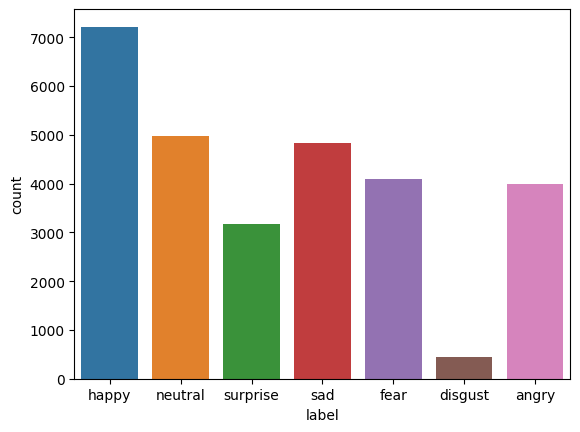

In [ ]:
sns.countplot(train['label'], x = train['label'])

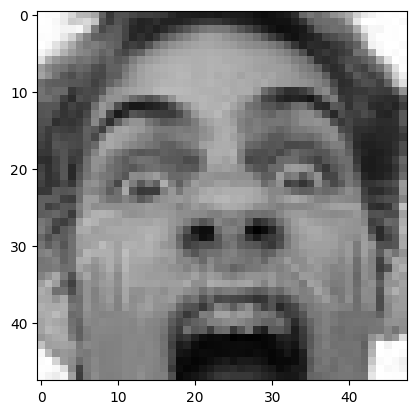

In [ ]:
from PIL import Image
img = Image.open(train['image'][0])
plt.imshow(img, cmap='gray');

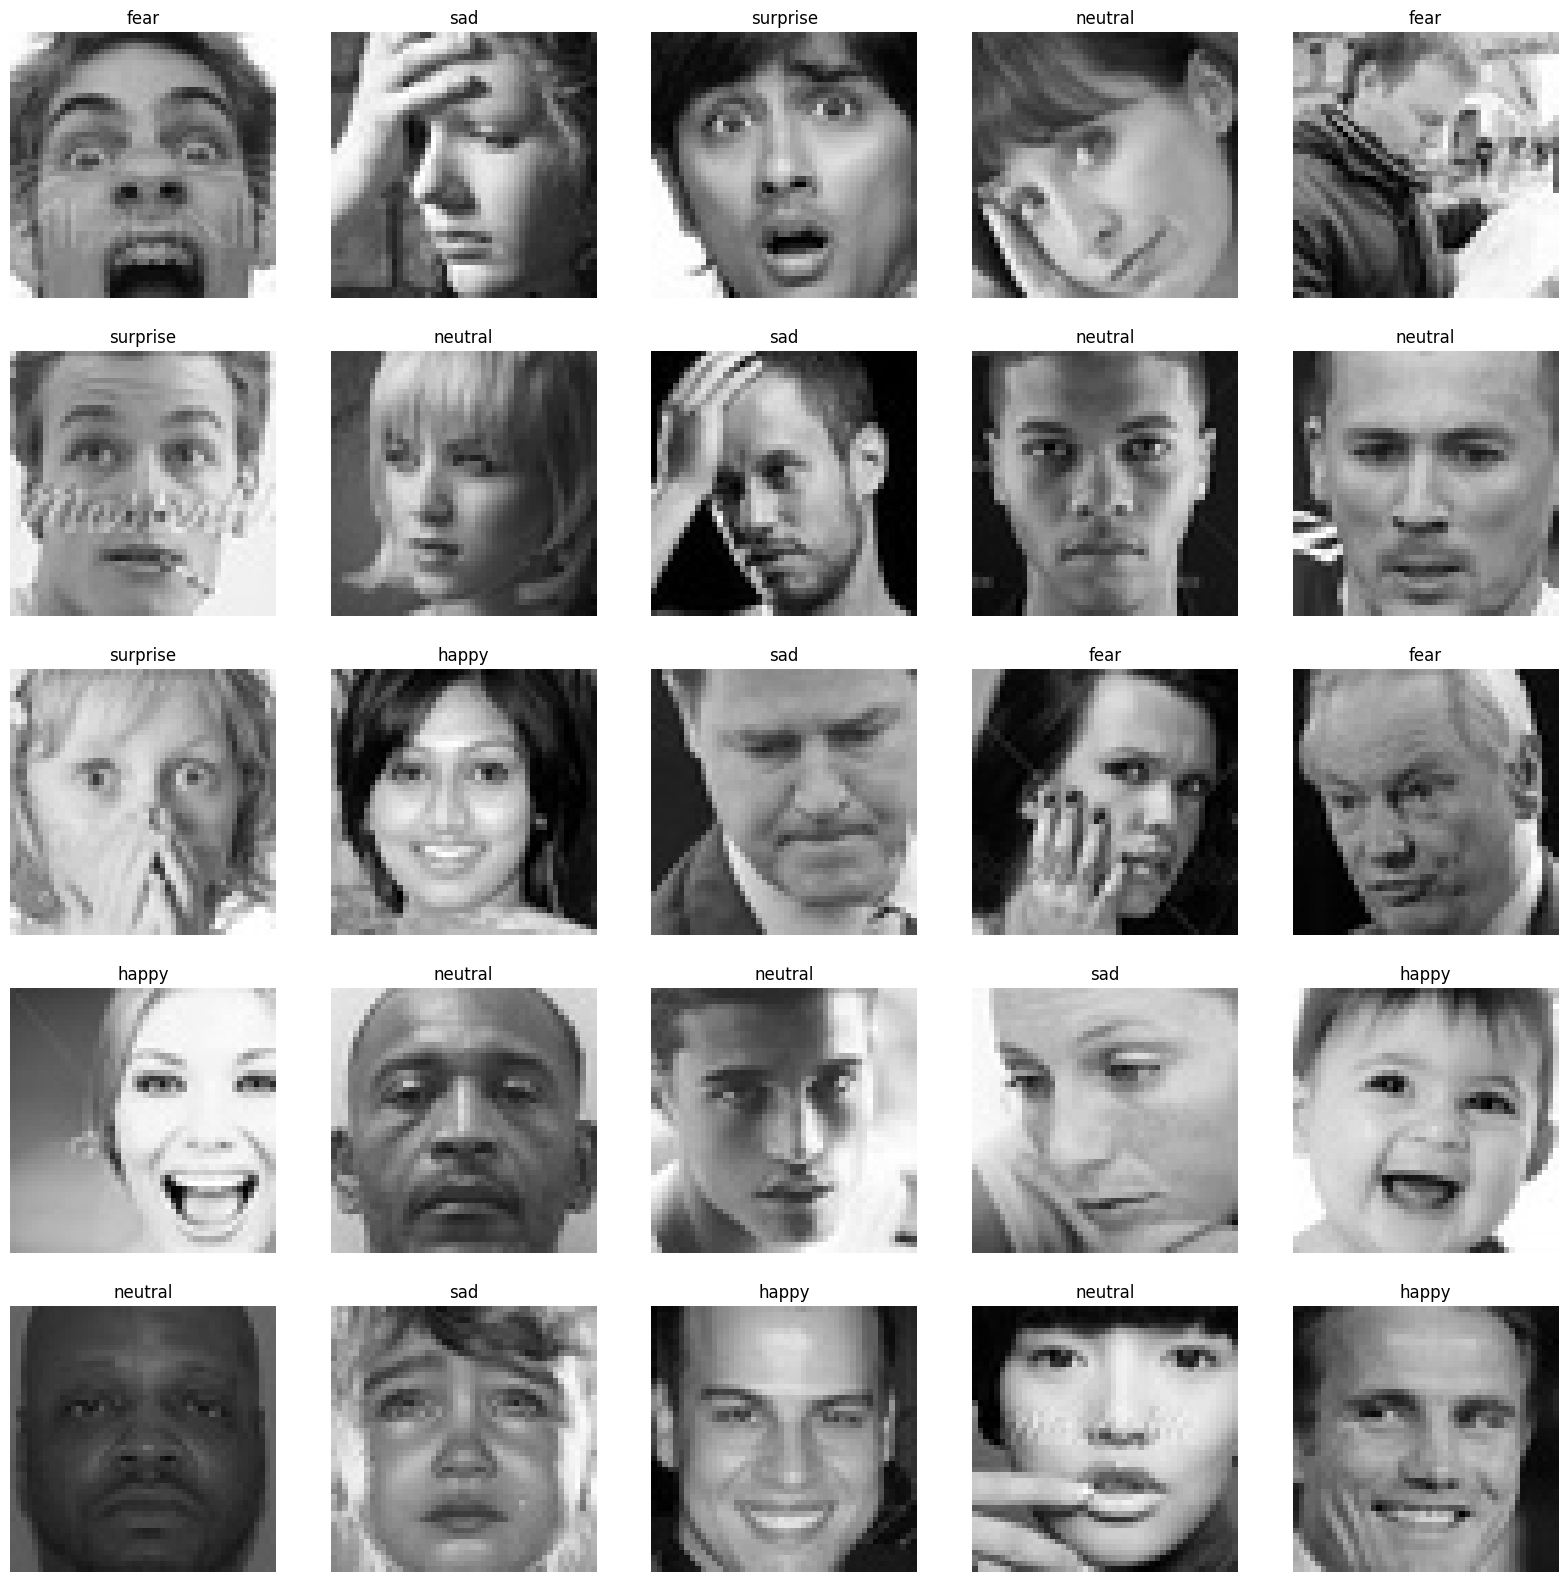

In [ ]:
# Afficher une grille des images
plt.figure(figsize=(20,20))
files = train.iloc[0:25]

for index, file, label in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')

## Extraction des features

In [ ]:
def extractFeatures(images):
    img = load_img(image, color_mode = "grayscale")
    img = np.array(img)
    return img

In [ ]:
def extract_feature(images):
    features = []
    for image in tqdm(images):
        img = load_img(image)
        img = np.array(img)
        features.append(img)
    features = np.array(features)
    features = features.reshape(len(features), 48, 48, 1)

In [ ]:
import numpy as np
from tqdm import tqdm

trainFeatures = []  # Une liste vide
for image in tqdm(train['image']):  # Boucle pour parcourir les images de train
    img = extractFeatures([image])  # Extraire les features de chaque image
    trainFeatures.append(img)  # Ajouter à la liste

# Convertir la liste des features en un tableau NumPy
trainFeatures = np.array(trainFeatures)

# Vérifier la forme avant de la remodeler (for debugging purposes)
print(f"Shape before reshaping: {trainFeatures.shape}")

# Remodeler le tableau en (number_of_images, height, width, 1) pour les images en niveaux de gris
try:
    trainFeatures = trainFeatures.reshape(len(trainFeatures), 48, 48, 1)
except ValueError as e:
    print(f"Error in reshaping: {e}")


100%|██████████| 28709/28709 [01:56<00:00, 247.23it/s]

Shape before reshaping: (28709, 48, 48)


In [ ]:
import numpy as np
from tqdm import tqdm

testFeatures = []  # Une liste vide
for image in tqdm(test['image']):  # Boucle pour parcourir les images de test
    img = extractFeatures([image])  # Extraire les features de chaque image
    testFeatures.append(img)  # Ajouter à la liste

# Convertir la liste des features en un tableau NumPy
testFeatures = np.array(testFeatures)

# Vérifier la forme avant de la remodeler (for debugging purposes)
print(f"Shape before reshaping: {testFeatures.shape}")

# Remodeler le tableau en (number_of_images, height, width, 1) pour les images en niveaux de gris
try:
    testFeatures = testFeatures.reshape(len(testFeatures), 48, 48, 1)
except ValueError as e:
    print(f"Error in reshaping: {e}")

100%|██████████| 7178/7178 [00:23<00:00, 305.27it/s]

Shape before reshaping: (7178, 48, 48)


In [ ]:
# Normaliser les images
xTrain = trainFeatures / 255.0
xTest = testFeatures / 255.0

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train['label'])
yTrain = le.transform(train['label'])
yTest = le.transform(test['label'])

In [ ]:
yTrain = to_categorical(yTrain, num_classes = 7)
yTest = to_categorical(yTest, num_classes = 7)

In [ ]:
yTrain[0]

array([0., 0., 0., 1., 0., 0., 0.])

In [ ]:
inputShape = (48, 48, 1)
output_class = 7

## Création du modèle

In [ ]:
model = Sequential()

# Convolutional layers with Batch Normalization
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', input_shape=inputShape))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

# Global Average Pooling instead of Flatten
model.add(Flatten())

# Fully connected layers
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))

# Output layer (softmax for multi-class classification)
model.add(Dense(output_class, activation='softmax'))

# Compiler le modele
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Entrainer le modèle
history = model.fit(x = xTrain, y = yTrain, batch_size = 128, epochs= 40, validation_data = (xTest, yTest))


Epoch 1/40


I0000 00:00:1729094338.175610      71 service.cc:145] XLA service 0x7c2fd0003850 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729094338.175695      71 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1729094338.175702      71 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  3/225 ━━━━━━━━━━━━━━━━━━━━ 12s 59ms/step - accuracy: 0.1797 - loss: 3.1997

I0000 00:00:1729094352.478116      71 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


225/225 ━━━━━━━━━━━━━━━━━━━━ 41s 102ms/step - accuracy: 0.2190 - loss: 2.0515 - val_accuracy: 0.2471 - val_loss: 1.8864
Epoch 2/40
225/225 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - accuracy: 0.3286 - loss: 1.6751 - val_accuracy: 0.3073 - val_loss: 1.7588
Epoch 3/40
225/225 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.4191 - loss: 1.4965 - val_accuracy: 0.4436 - val_loss: 1.4234
Epoch 4/40
225/225 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.4777 - loss: 1.3591 - val_accuracy: 0.4501 - val_loss: 1.3769
Epoch 5/40
225/225 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.5099 - loss: 1.2895 - val_accuracy: 0.4563 - val_loss: 1.4041
Epoch 6/40
225/225 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.5421 - loss: 1.2180 - val_accuracy: 0.5486 - val_loss: 1.1897
Epoch 7/40
225/225 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.5503 - loss: 1.1811 - val_accuracy: 0.5011 - val_loss: 1.2713
Epoch 8/40
225/225 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.5685 - loss: 1.1435 - val_accura

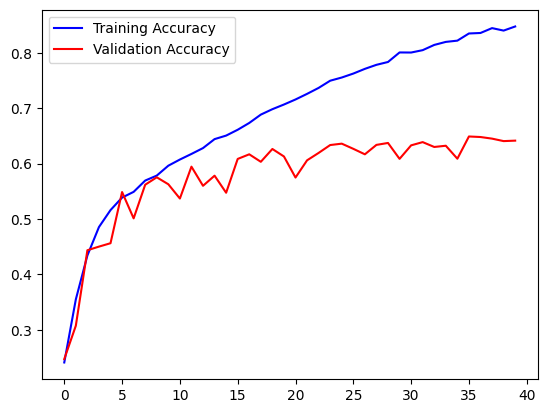

In [ ]:
# Les courbes ROC des précisions
acc = history.history['accuracy']
val_acc=history.history['val_accuracy']
epochs=range(len(acc))

plt.plot(epochs,acc,'b',label="Training Accuracy")
plt.plot(epochs,val_acc,'r',label="Validation Accuracy")
plt.legend()



plt.show()


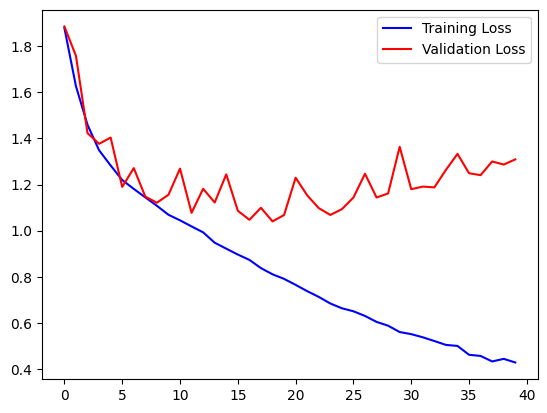

In [ ]:
# Les courbes ROC des perd
loss = history.history['loss']
val_loss=history.history['val_loss']
epochs=range(len(loss))

plt.plot(epochs,loss,'b',label="Training Loss")
plt.plot(epochs,val_loss,'r',label="Validation Loss")
plt.legend()


## Validation

Original Output: happy
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 719ms/step
Predicted Output: happy


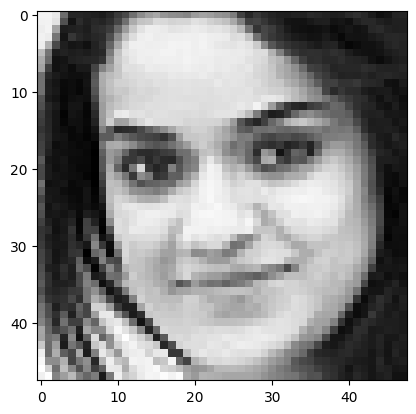

In [ ]:
import random
image_index = random.randint(0,len(test))
print("Original Output:",test['label'][image_index])
pred= model.predict(xTest[image_index].reshape(1,48,48,1))
prediction_label = le.inverse_transform([pred.argmax()])[0]
print("Predicted Output:",prediction_label)
plt.imshow(xTest[image_index].reshape(48,48),cmap='gray')


In [ ]:
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 46, 46, 128)    │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 46, 46, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 23, 23, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 23, 23, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 21, 21, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 21, 21, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 10, 10, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 10, 10, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 8, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 2, 2, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 1, 1, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1, 1, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,707,863 (48.48 MB)

 Trainable params: 4,235,015 (16.16 MB)

 Non-trainable params: 2,816 (11.00 KB)

 Optimizer params: 8,470,032 (32.31 MB)

## VGG16, ResNet50 et InceptionV3

In [ ]:
from keras.preprocessing.image import img_to_array
from keras.applications import VGG16, ResNet50, InceptionV3
from keras.models import Sequential
from keras.optimizers import Adam
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Paramètres du modèle
input_shape = (224, 224, 3)
output_class = yTrain.shape[1]
learning_rate = 0.0001
batch_size = 32

# Fonction pour construire un modèle avec une base pré-entraînée
def build_model(base_model):
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(output_class, activation='softmax')
    ])
    base_model.trainable = False
    return model

# Charger les modèles pré-entraînés
vgg_model = build_model(VGG16(weights='imagenet', include_top=False, input_shape=input_shape))
resnet_model = build_model(ResNet50(weights='imagenet', include_top=False, input_shape=input_shape))
inception_model = build_model(InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape))

# Compiler les modèles
for model in [vgg_model, resnet_model, inception_model]:
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

# Entraîner les modèles
vgg_model.fit(xTrain, yTrain, batch_size=batch_size, epochs=5, validation_data=(xTest, yTest))
resnet_model.fit(xTrain, yTrain, batch_size=batch_size, epochs=5, validation_data=(xTest, yTest))
inception_model.fit(xTrain, yTrain, batch_size=batch_size, epochs=5, validation_data=(xTest, yTest))

# Prédictions des modèles
vgg_preds = vgg_model.predict(xTest)
resnet_preds = resnet_model.predict(xTest)
inception_preds = inception_model.predict(xTest)

# Combiner les prédictions pour le stacking
stacked_features = np.concatenate([vgg_preds, resnet_preds, inception_preds], axis=1)
stacked_labels = np.argmax(yTest, axis=1)

# Entraîner un méta-modèle de stacking
meta_model = RandomForestClassifier(n_estimators=100, random_state=42)
meta_model.fit(stacked_features, stacked_labels)

# Prédictions finales
stacked_preds = meta_model.predict(stacked_features)

# Évaluer la précision
ensemble_accuracy = accuracy_score(stacked_labels, stacked_preds)
print(f"Précision finale avec stacking : {ensemble_accuracy * 100:.2f}%")
